## 資料集
https://drive.google.com/file/d/1wqKYZYID3h29vxMmE1rPsDSLoTwtFMZn/view
## 其他資料
模型：https://drive.google.com/file/d/1odkbDSA6O07X1BAbWppLo7wPjuVqbDlI/view

截圖模型：https://drive.google.com/file/d/1Cq94EzMj7lM25_OxFHRfN2nE-zHt7IHe/view



In [ ]:
# Import data
from google.colab import drive
drive.mount('/content/drive')

# Unzip data
!unzip -qq ./drive/My\ Drive/fashion.zip

Mounted at /content/drive


In [ ]:
import pandas as pd
df = pd.read_csv('drive/MyDrive/model.csv')
df.head(2)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image,input_text,image_vec,word_vec,sum_vec,con_vec
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,images/15970.jpg,men shirts navy blue fall casual turtle check ...,[5.95007420e-01 8.08914006e-01 8.00609350e-01 ...,[-3.11446264e-02 -1.59385800e-03 3.18947554e-...,[ 5.6386280e-01 8.0732012e-01 1.1195569e+00 ...,[ 5.95007420e-01 8.08914006e-01 8.00609350e-...
1,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,images/53759.jpg,men tshirts grey summer casual puma men grey t...,[2.14686409e-01 1.86115339e-01 6.97782278e-01 ...,[ 0.19691536 0.06231774 0.19671741 -0.663782...,[ 4.11601782e-01 2.48433083e-01 8.94499660e-...,[ 2.14686409e-01 1.86115339e-01 6.97782278e-...


In [ ]:
df.image_vec = df.image_vec.str.strip('[]')
df.word_vec = df.word_vec.str.strip('[]')
df.sum_vec = df.sum_vec.str.strip('[]')
df.con_vec = df.con_vec.str.strip('[]')
df = df.replace('\\n', '', regex=True)
df = df.replace({' +':' '}, regex=True)
df.head(2)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image,input_text,image_vec,word_vec,sum_vec,con_vec
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,images/15970.jpg,men shirts navy blue fall casual turtle check ...,5.95007420e-01 8.08914006e-01 8.00609350e-01 1...,-3.11446264e-02 -1.59385800e-03 3.18947554e-01...,5.6386280e-01 8.0732012e-01 1.1195569e+00 -2....,5.95007420e-01 8.08914006e-01 8.00609350e-01 ...
1,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,images/53759.jpg,men tshirts grey summer casual puma men grey t...,2.14686409e-01 1.86115339e-01 6.97782278e-01 1...,0.19691536 0.06231774 0.19671741 -0.6637827 -...,4.11601782e-01 2.48433083e-01 8.94499660e-01 ...,2.14686409e-01 1.86115339e-01 6.97782278e-01 ...


In [ ]:
import numpy as np
df.image_vec = df.image_vec.apply(lambda x: np.fromstring(x, dtype=float, sep=' '))
df.word_vec = df.word_vec.apply(lambda x: np.fromstring(x, dtype=float, sep=' '))
df.sum_vec = df.sum_vec.apply(lambda x: np.fromstring(x, dtype=float, sep=' '))
df.con_vec = df.con_vec.apply(lambda x: np.fromstring(x, dtype=float, sep=' '))

In [ ]:
#np.set_printoptions(threshold=np.inf)
df.con_vec[0]

array([ 0.59500742,  0.80891401,  0.80060935, ..., -0.0009096 ,
       -0.31868297,  0.21400072])

In [ ]:
import torch
#torch.set_printoptions(precision=8)
torch.Tensor(df.con_vec[0])

tensor([ 0.5950,  0.8089,  0.8006,  ..., -0.0009, -0.3187,  0.2140])

In [ ]:
df.sum_vec = df.sum_vec.apply(lambda x: torch.Tensor(x))
df.con_vec = df.con_vec.apply(lambda x: torch.Tensor(x))

In [ ]:
df.head(2)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image,input_text,image_vec,word_vec,sum_vec,con_vec
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,images/15970.jpg,men shirts navy blue fall casual turtle check ...,"[0.59500742, 0.808914006, 0.80060935, 0.182420...","[-0.0311446264, -0.001593858, 0.318947554, -0....","[tensor(0.5639), tensor(0.8073), tensor(1.1196...","[tensor(0.5950), tensor(0.8089), tensor(0.8006..."
1,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,images/53759.jpg,men tshirts grey summer casual puma men grey t...,"[0.214686409, 0.186115339, 0.697782278, 0.1269...","[0.19691536, 0.06231774, 0.19671741, -0.663782...","[tensor(0.4116), tensor(0.2484), tensor(0.8945...","[tensor(0.2147), tensor(0.1861), tensor(0.6978..."


In [ ]:
import torch
import torchvision
import torchvision.models as models
from PIL import Image

# Load the pretrained model
model = models.resnet34(pretrained=True)
model.cuda()
# Use the model object to select the desired layer
layer = model._modules.get('avgpool')
# Set model to evaluation mode
model.eval()
transforms = torchvision.transforms.Compose([
  torchvision.transforms.Resize(256),
  torchvision.transforms.CenterCrop(224),
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def get_vector(image_name):
  # 1. Load the image with Pillow library
  img = Image.open(image_name).convert('RGB')
  # 2. Create a PyTorch Variable with the transformed image
  t_img = transforms(img)
  t_img = t_img.cuda()
  # 3. Create a vector of zeros that will hold our feature vector
  #    The 'avgpool' layer has an output size of 512
  my_embedding = torch.zeros(512)
  # 4. Define a function that will copy the output of a layer
  def copy_data(m, i, o):
      my_embedding.copy_(o.flatten())
  # 5. Attach that function to our selected layer
  h = layer.register_forward_hook(copy_data)
  # 6. Run the model on our transformed image
  with torch.no_grad():
    model(t_img.unsqueeze(0)) # 扩展维度
  # 7. Detach our copy function from the layer
  h.remove()
  # 8. Return the feature vector
  return my_embedding

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
!pip install -U sentence-transformers

     |████████████████████████████████| 71kB 6.5MB/s 
     |████████████████████████████████| 1.5MB 19.7MB/s 
     |████████████████████████████████| 1.1MB 49.1MB/s 
     |████████████████████████████████| 890kB 51.5MB/s 
     |████████████████████████████████| 2.9MB 49.4MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.4.0-cp36-none-any.whl size=102655 sha256=e58461633a86d21596f5f5694f2639f27e30ae25631e678091fde757d73b575b
  Stored in directory: /root/.cache/pip/wheels/ff/76/65/50258d8b7930e909ea2f5bd006a23d520a16765af13ab45bb3
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=a4a8ac30afe71bd418bfe8290ca11f93ccd03ccdb1cf98283fc08106de3a0320
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


In [ ]:
import torch
import torch.nn as nn 
from sentence_transformers import SentenceTransformer, util, models

modelw = SentenceTransformer('distilbert-base-nli-mean-tokens')
new_dimension = 512

dense = models.Dense(in_features=modelw.get_sentence_embedding_dimension(), out_features=new_dimension, bias=False, activation_function=torch.nn.Identity())
modelw.add_module('dense', dense)

print(modelw)

100%|██████████| 245M/245M [00:10<00:00, 23.0MB/s]


SentenceTransformer(
  (0): Transformer(
    (auto_model): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0): TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (ffn): FFN(
              (dro

In [ ]:
def sim(image_v, word_v, y, mode):
  if mode == 0: # sum
    fv = image_v + word_v
  else: # concatenation
    fv = torch.cat((image_v, word_v), 0)

  cos = nn.CosineSimilarity(dim=1, eps=1e-6)
  cos_sim = cos(fv.unsqueeze(0), y.unsqueeze(0))

  return cos_sim

blue sport


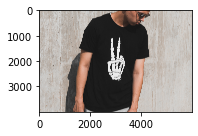

In [ ]:
import matplotlib.pyplot as plt
import cv2 as cv

# input
image = "drive/MyDrive/test.jpg"
word = "blue sport"
image_v = get_vector(image)
word_v = modelw.encode(word, convert_to_tensor=True)

print(word)
plt.subplot(1, 2, 1)
plt.imshow(cv.imread(image)[:, :, ::-1])
plt.show()

In [ ]:
df['similarity_sum'] = df['sum_vec'].apply(lambda x: sim(image_v, word_v, x, 0))
df['similarity_con'] = df['con_vec'].apply(lambda x: sim(image_v, word_v, x, 1))
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image,input_text,image_vec,word_vec,sum_vec,con_vec,similarity_sum,similarity_con
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,images/15970.jpg,men shirts navy blue fall casual turtle check ...,"[0.59500742, 0.808914006, 0.80060935, 0.182420...","[-0.0311446264, -0.001593858, 0.318947554, -0....","[tensor(0.5639), tensor(0.8073), tensor(1.1196...","[tensor(0.5950), tensor(0.8089), tensor(0.8006...",[tensor(0.6041)],[tensor(0.6080)]
1,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,images/53759.jpg,men tshirts grey summer casual puma men grey t...,"[0.214686409, 0.186115339, 0.697782278, 0.1269...","[0.19691536, 0.06231774, 0.19671741, -0.663782...","[tensor(0.4116), tensor(0.2484), tensor(0.8945...","[tensor(0.2147), tensor(0.1861), tensor(0.6978...",[tensor(0.6132)],[tensor(0.6324)]
2,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt,images/1855.jpg,men tshirts grey summer casual inkfruit mens c...,"[1.02767456, 1.14501941, 0.365850389, 0.060327...","[0.16101071, 0.14295577, 0.19329849, -0.633813...","[tensor(1.1887), tensor(1.2880), tensor(0.5591...","[tensor(1.0277), tensor(1.1450), tensor(0.3659...",[tensor(0.6314)],[tensor(0.6392)]
3,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012.0,Ethnic,Fabindia Men Striped Green Shirt,images/30805.jpg,men shirts green summer ethnic fabindia men st...,"[0.541225016, 0.905860186, 0.554687977, 0.1755...","[0.130205005, 0.0875357166, 0.240634069, -0.93...","[tensor(0.6714), tensor(0.9934), tensor(0.7953...","[tensor(0.5412), tensor(0.9059), tensor(0.5547...",[tensor(0.5951)],[tensor(0.6009)]
4,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012.0,Casual,Jealous 21 Women Purple Shirt,images/26960.jpg,women shirts purple summer casual jealous wome...,"[1.1716367, 0.166932955, 0.299115807, 0.323090...","[0.191782072, 0.347535282, -0.316194236, -0.10...","[tensor(1.3634), tensor(0.5145), tensor(-0.017...","[tensor(1.1716), tensor(0.1669), tensor(0.2991...",[tensor(0.6063)],[tensor(0.6134)]


In [ ]:
rec_df = df.copy()
rec_df.sort_values('similarity_con', inplace=True, ascending=False)
rec_df = rec_df.reset_index(drop=True)
rec_df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image,input_text,image_vec,word_vec,sum_vec,con_vec,similarity_sum,similarity_con
0,3365,Men,Apparel,Topwear,Tshirts,Black,Summer,2011.0,Casual,Myntra Men's Brain Black T-shirt,images/3365.jpg,men tshirts black summer casual myntra mens br...,"[1.51568115, 1.04728103, 0.0459099486, 0.13806...","[0.161217868, 0.26004976, 0.414260566, -0.4608...","[tensor(1.6769), tensor(1.3073), tensor(0.4602...","[tensor(1.5157), tensor(1.0473), tensor(0.0459...",[tensor(0.7356)],[tensor(0.7427)]
1,5492,Men,Apparel,Topwear,Tshirts,Blue,Summer,2011.0,Casual,Mr.Men Men's Cool Indigo T-shirt,images/5492.jpg,men tshirts blue summer casual mrmen mens cool...,"[0.53194207, 2.366714, 0.31741181, 0.336866945...","[0.0970680043, 0.379285365, 0.232280552, -0.49...","[tensor(0.6290), tensor(2.7460), tensor(0.5497...","[tensor(0.5319), tensor(2.3667), tensor(0.3174...",[tensor(0.7417)],[tensor(0.7411)]
2,28483,Men,Apparel,Topwear,Tshirts,Purple,Fall,2012.0,Casual,Urban Yoga Men Purple Tshirt,images/28483.jpg,men tshirts purple fall casual urban yoga men ...,"[1.10186148, 1.25888932, 0.250752151, 0.182349...","[-0.312172115, -0.0938071012, -0.245525792, -0...","[tensor(0.7897), tensor(1.1651), tensor(0.0052...","[tensor(1.1019), tensor(1.2589), tensor(0.2508...",[tensor(0.7266)],[tensor(0.7399)]
3,6941,Men,Apparel,Topwear,Tshirts,Blue,Summer,2011.0,Casual,Tantra Men's Decade Ago Blue T-shirt,images/6941.jpg,men tshirts blue summer casual tantra mens dec...,"[0.516606748, 1.07175148, 0.721422672, 0.25245...","[0.0668751225, 0.189605951, 0.19689554, -0.808...","[tensor(0.5835), tensor(1.2614), tensor(0.9183...","[tensor(0.5166), tensor(1.0718), tensor(0.7214...",[tensor(0.7249)],[tensor(0.7391)]
4,3434,Men,Apparel,Topwear,Tshirts,Black,Summer,2011.0,Casual,Myntra Mens So You Love Me T-shirt,images/3434.jpg,men tshirts black summer casual myntra mens so...,"[0.533561468, 0.247010499, 0.818366289, 0.1814...","[-0.0618711561, 0.264531493, 0.264329016, -0.3...","[tensor(0.4717), tensor(0.5115), tensor(1.0827...","[tensor(0.5336), tensor(0.2470), tensor(0.8184...",[tensor(0.7282)],[tensor(0.7391)]


id                                                                 3365
gender                                                              Men
masterCategory                                                  Apparel
subCategory                                                     Topwear
articleType                                                     Tshirts
baseColour                                                        Black
season                                                           Summer
year                                                               2011
usage                                                            Casual
productDisplayName                     Myntra Men's Brain Black T-shirt
image                                                   images/3365.jpg
input_text            men tshirts black summer casual myntra mens br...
image_vec             [1.51568115, 1.04728103, 0.0459099486, 0.13806...
word_vec              [0.161217868, 0.26004976, 0.414260566, -0.

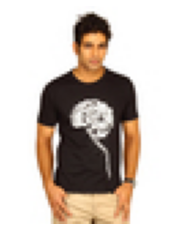

id                                                                 5492
gender                                                              Men
masterCategory                                                  Apparel
subCategory                                                     Topwear
articleType                                                     Tshirts
baseColour                                                         Blue
season                                                           Summer
year                                                               2011
usage                                                            Casual
productDisplayName                     Mr.Men Men's Cool Indigo T-shirt
image                                                   images/5492.jpg
input_text            men tshirts blue summer casual mrmen mens cool...
image_vec             [0.53194207, 2.366714, 0.31741181, 0.336866945...
word_vec              [0.0970680043, 0.379285365, 0.232280552, -

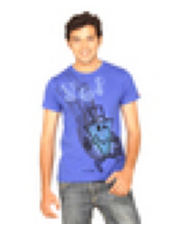

id                                                                28483
gender                                                              Men
masterCategory                                                  Apparel
subCategory                                                     Topwear
articleType                                                     Tshirts
baseColour                                                       Purple
season                                                             Fall
year                                                               2012
usage                                                            Casual
productDisplayName                         Urban Yoga Men Purple Tshirt
image                                                  images/28483.jpg
input_text            men tshirts purple fall casual urban yoga men ...
image_vec             [1.10186148, 1.25888932, 0.250752151, 0.182349...
word_vec              [-0.312172115, -0.0938071012, -0.245525792

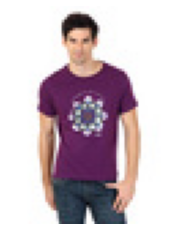

id                                                                 6941
gender                                                              Men
masterCategory                                                  Apparel
subCategory                                                     Topwear
articleType                                                     Tshirts
baseColour                                                         Blue
season                                                           Summer
year                                                               2011
usage                                                            Casual
productDisplayName                 Tantra Men's Decade Ago Blue T-shirt
image                                                   images/6941.jpg
input_text            men tshirts blue summer casual tantra mens dec...
image_vec             [0.516606748, 1.07175148, 0.721422672, 0.25245...
word_vec              [0.0668751225, 0.189605951, 0.19689554, -0

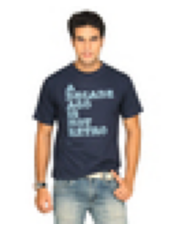

id                                                                 3434
gender                                                              Men
masterCategory                                                  Apparel
subCategory                                                     Topwear
articleType                                                     Tshirts
baseColour                                                        Black
season                                                           Summer
year                                                               2011
usage                                                            Casual
productDisplayName                   Myntra Mens So You Love Me T-shirt
image                                                   images/3434.jpg
input_text            men tshirts black summer casual myntra mens so...
image_vec             [0.533561468, 0.247010499, 0.818366289, 0.1814...
word_vec              [-0.0618711561, 0.264531493, 0.264329016, 

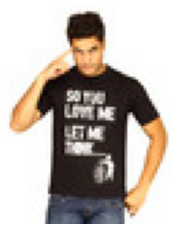

In [ ]:
# Show top 5
for i, c in rec_df.iloc[:5].iterrows():
  rec = cv.imread(c.image)[:, :, ::-1] # reverse the channel order, because OpenCV reads image in BGR order
  plt.figure()
  print(c)
  plt.imshow(rec)
  plt.axis("off")
  plt.show()

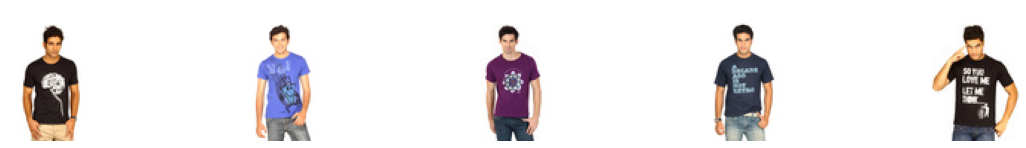

In [ ]:
plt.figure(figsize=(20,10))
columns = 5
for i, c in rec_df.iloc[:5].iterrows():
  rec = cv.imread(c.image)[:, :, ::-1]
  plt.subplot(len(c.image) / columns + 1, columns, i + 1).set_title('Top {}' .format(i+1), color='white')
  plt.axis("off")
  plt.imshow(rec)

In [ ]:
mylist = word
mylist = mylist.split()
#pattern = '|'.join(mylist)
#pattern
mylist

['blue', 'sport']

In [ ]:
# Reference https://stackoverflow.com/questions/37011734/pandas-dataframe-str-contains-and-operation
base = r'^{}'
expr = '(?=.*{})'
base = base.format(''.join(expr.format(w) for w in mylist))
base

'^(?=.*blue)(?=.*sport)'

id                                                                 7666
gender                                                              Men
masterCategory                                                  Apparel
subCategory                                                     Topwear
articleType                                                     Tshirts
baseColour                                                         Blue
season                                                             Fall
year                                                               2011
usage                                                            Sports
productDisplayName                  Puma Men's Silly Point Blue T-shirt
image                                                   images/7666.jpg
input_text            men tshirts blue fall sports puma mens silly p...
image_vec             [1.20639336, 1.16069853, 0.544063151, 0.015081...
word_vec              [-0.2754606, 0.3669902, 0.1913286, -0.5446

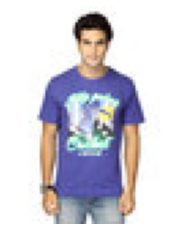

id                                                                 7637
gender                                                              Men
masterCategory                                                  Apparel
subCategory                                                     Topwear
articleType                                                     Tshirts
baseColour                                                         Blue
season                                                             Fall
year                                                               2011
usage                                                            Sports
productDisplayName                       Puma Men's Slogan Blue T-shirt
image                                                   images/7637.jpg
input_text            men tshirts blue fall sports puma mens slogan ...
image_vec             [0.286793143, 1.54043329, 0.0204062108, 0.4231...
word_vec              [-0.3497472, 0.17513376, 0.1411325, -0.496

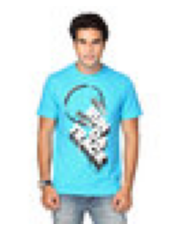

id                                                                 1947
gender                                                              Men
masterCategory                                                  Apparel
subCategory                                                     Topwear
articleType                                                     Tshirts
baseColour                                                         Blue
season                                                             Fall
year                                                               2010
usage                                                            Sports
productDisplayName                Puma Mens Cricket Way of Life T-shirt
image                                                   images/1947.jpg
input_text            men tshirts blue fall sports puma mens cricket...
image_vec             [0.384042233, 0.968622983, 0.267098099, 0.0530...
word_vec              [-0.37158355, 0.3210677, 0.1074629, -0.575

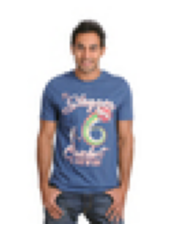

id                                                                31038
gender                                                              Men
masterCategory                                                  Apparel
subCategory                                                     Topwear
articleType                                                     Tshirts
baseColour                                                         Blue
season                                                           Summer
year                                                               2012
usage                                                            Casual
productDisplayName                 Arrow Sport Men blue Printed T-shirt
image                                                  images/31038.jpg
input_text            men tshirts blue summer casual arrow sport men...
image_vec             [1.41403377, 1.19276249, 0.0543687008, 0.07576...
word_vec              [-0.138063937, 0.162739664, 0.243716151, -

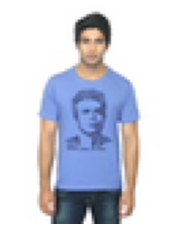

id                                                                 5828
gender                                                              Men
masterCategory                                                  Apparel
subCategory                                                     Topwear
articleType                                                     Tshirts
baseColour                                                         Blue
season                                                           Summer
year                                                               2011
usage                                                            Sports
productDisplayName                      Puma Men's Edition Blue T-shirt
image                                                   images/5828.jpg
input_text            men tshirts blue summer sports puma mens editi...
image_vec             [0.482523471, 1.8258059, 0.7795856, 0.06608606...
word_vec              [-0.247461796, 0.276591033, 0.239208594, -

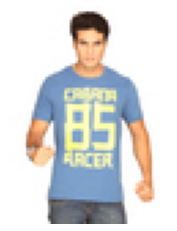

In [ ]:
for i, c in rec_df.loc[(rec_df['input_text'].str.contains(base))].iloc[:5].iterrows():
  rec = cv.imread(c.image)[:, :, ::-1] # reverse the channel order, because OpenCV reads image in BGR order
  plt.figure()
  print(c)
  plt.imshow(rec)
  plt.axis("off")
  plt.show()

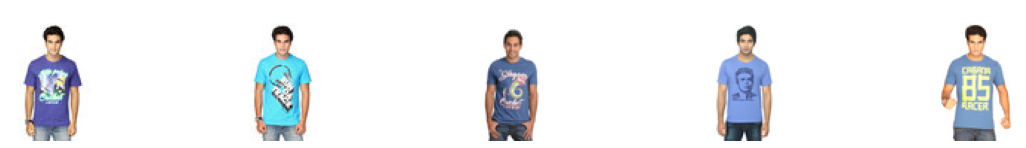

In [ ]:
plt.figure(figsize=(20,10))
columns = 5
ii = 1
for i, c in rec_df.loc[(rec_df['input_text'].str.contains(base))].iloc[:5].iterrows():
  rec = cv.imread(c.image)[:, :, ::-1]
  plt.subplot(len(c.image) / columns + 1, columns, ii).set_title('Top {}' .format(ii), color='white')
  plt.imshow(rec)
  plt.axis("off")
  ii+=1

id                                                                 7666
gender                                                              Men
masterCategory                                                  Apparel
subCategory                                                     Topwear
articleType                                                     Tshirts
baseColour                                                         Blue
season                                                             Fall
year                                                               2011
usage                                                            Sports
productDisplayName                  Puma Men's Silly Point Blue T-shirt
image                                                   images/7666.jpg
input_text            men tshirts blue fall sports puma mens silly p...
image_vec             [1.20639336, 1.16069853, 0.544063151, 0.015081...
word_vec              [-0.2754606, 0.3669902, 0.1913286, -0.5446

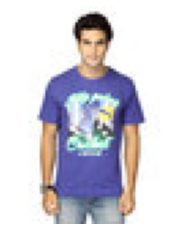

In [ ]:
top_1 = ""

for i, c in rec_df.loc[(rec_df['input_text'].str.contains(base))].iloc[:1].iterrows(): 
  top_1 = c.image
  rec = cv.imread(c.image)[:, :, ::-1] # reverse the channel order, because OpenCV reads image in BGR order
  print(c)
  plt.figure()
  plt.imshow(rec)
  plt.axis("off")
  plt.show()

In [ ]:
!mkdir clothes
!mkdir "clothes/cloth"
!mkdir "clothes/cloth mask"

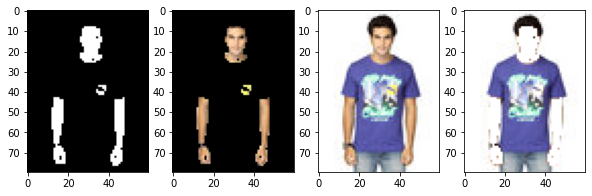

True

In [ ]:
import cv2
# remove skin
min_HSV = np.array([0, 58, 80], dtype = "uint8")
max_HSV = np.array([33, 255, 255], dtype = "uint8")
image = cv2.imread(top_1)[:, :, ::-1] 
imageHSV = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
skinRegionHSV = cv2.inRange(imageHSV, min_HSV, max_HSV)

skinHSV = cv2.bitwise_and(image, image, mask = skinRegionHSV) # 從圖片選取skin
clothes = cv2.subtract(image, skinHSV) # remove skin

clothes[np.where((clothes==[0,0,0]).all(axis=2))] = [255,255,255] # convert black pixles to white

r = 4
plt.figure(figsize=(10, 10))
plt.subplot(1, r, 1)
plt.imshow(skinRegionHSV, cmap="gray")
plt.subplot(1, r, 2)
plt.imshow(skinHSV)
plt.subplot(1, r, 3)
plt.imshow(image)
plt.subplot(1, r, 4)
plt.imshow(clothes)
plt.show()
cv2.imwrite("clothes.jpg", clothes[:, :, ::-1])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


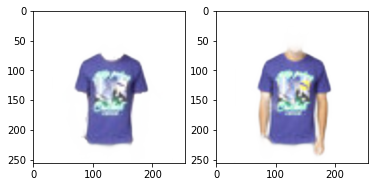

In [ ]:
#Reference https://github.com/anish9/Fashion-AI-segmentation
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import tensorflow as tf
import sys
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

#f = sys.argv[1] # input file name

saved = load_model('drive/MyDrive/save_ckp_frozen.h5')

class fashion_tools(object):
    def __init__(self,imageid,model,version=1.1):
        self.imageid = imageid
        self.model   = model
        self.version = version
        
    def get_dress(self,stack=False):
        """limited to top wear and full body dresses (wild and studio working)"""
        """takes input rgb----> return PNG"""
        name =  self.imageid
        file = cv2.imread(name)
        file = tf.image.resize_with_pad(file,target_height=256,target_width=256)
        rgb  = file.numpy()
        file = np.expand_dims(file,axis=0)/ 255.
        seq = self.model.predict(file)
        seq = seq[3][0,:,:,0]
        seq = np.expand_dims(seq,axis=-1)
        c1x = rgb*seq
        c2x = rgb*(1-seq)
        cfx = c1x+c2x
        dummy = np.ones((rgb.shape[0],rgb.shape[1],1))
        rgbx = np.concatenate((rgb,dummy*255),axis=-1)
        rgbs = np.concatenate((cfx,seq*255.),axis=-1)
        #if stack:
            #stacked = np.hstack((rgbx,rgbs)) # 合併原圖
            #return stacked
        #else:
            #return rgbs
        return rgbs
          
    def get_patch(self):
        return None

api    = fashion_tools("clothes.jpg", saved)
image_ = api.get_dress(True)
cv2.imwrite("out_rs.png", image_)
api    = fashion_tools(top_1, saved)
image_ = api.get_dress(True)
cv2.imwrite("out.png", image_)

import matplotlib.image as mpimg
plt.subplot(1, 2, 1)
plt.imshow(mpimg.imread("out_rs.png"))
plt.subplot(1, 2, 2)
plt.imshow(mpimg.imread("out.png"))
plt.show()

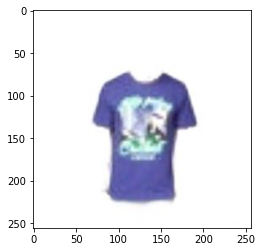

In [ ]:
# Convert png to jpeg
# Reference https://stackoverflow.com/questions/9166400/convert-rgba-png-to-rgb-with-pil/33507138#33507138
from PIL import Image

im = Image.open("out_rs.png")
bg = Image.new("RGB", im.size, (255,255,255))
bg.paste(im, im)
bg.save("clothes/cloth/cloth_01.jpg")
i = cv2.imread('clothes/cloth/cloth_01.jpg')[:, :, ::-1]
plt.imshow(i)

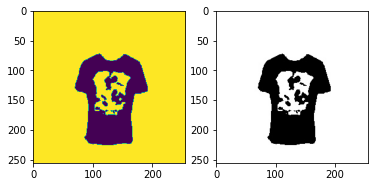

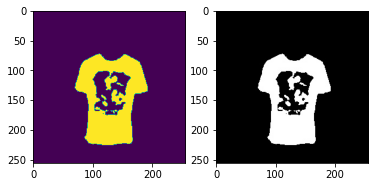

In [ ]:
# Reference https://stackoverflow.com/questions/7624765/converting-an-opencv-image-to-black-and-white
im_gray = cv2.imread('clothes/cloth/cloth_01.jpg', cv2.IMREAD_GRAYSCALE)
(thresh, im_bw) = cv2.threshold(im_gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
cv2.imwrite('black.jpg', im_bw)

plt.subplot(1, 2, 1)
plt.imshow(im_bw)
plt.subplot(1, 2, 2)
plt.imshow(cv2.imread('black.jpg'))
plt.show()

# Reference https://stackoverflow.com/questions/19580102/inverting-image-in-python-with-opencv
mask = cv2.bitwise_not(im_bw)
cv2.imwrite('clothes/cloth mask/cloth_mask_01.jpg', mask)
plt.subplot(1, 2, 1)
plt.imshow(mask)
plt.subplot(1, 2, 2)
plt.imshow(cv2.imread('clothes/cloth mask/cloth_mask_01.jpg'))
plt.show()